In [92]:
from seagul.rl.ars.ars_pipe import ars
from seagul.nn import MLP
from common import *
from seagul.mesh import create_mesh, variation_dim, compute_meshdim
import scipy.optimize as opt
import torch
import matplotlib.pyplot as plt
import time
import copy
import gym
import torch

import xarray as xr
import numpy as np
import pandas as pd

import os


def fit_and_plot(start,stop):
    xdata = np.log2(dv[start:stop])
    ydata = np.log2(ms[start:stop])
    #plt.plot(xdata, ydata,'x')

    def f(x, m, b):
        return m * x + b
    popt, pcov = opt.curve_fit(f, xdata, ydata)
    plt.plot(xdata0, popt[0]*xdata0 + popt[1])
    return popt[0]

In [10]:
def do_rollout(env, policy, render=False):
    torch.autograd.set_grad_enabled(False)

    act_list = []
    obs_list = []
    rew_list = []

    dtype = torch.float32
    obs = env.reset()
    done = False
    cur_step = 0

    while not done:
        obs = torch.as_tensor(obs, dtype=dtype).detach()
        obs_list.append(obs.clone())

        act = policy(obs)
        obs, rew, done, _ = env.step(act.numpy())
        if render:
            env.render()
            time.sleep(.01)

        act_list.append(torch.as_tensor(act.clone()))
        rew_list.append(rew)

        cur_step += 1

    ep_length = len(rew_list)
    ep_obs = torch.stack(obs_list)
    ep_act = torch.stack(act_list)
    ep_rew = torch.tensor(rew_list, dtype=dtype)
    ep_rew = ep_rew.reshape(-1, 1)

    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew, ep_length




<Figure size 432x288 with 0 Axes>

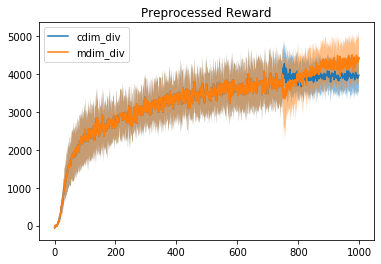

<Figure size 432x288 with 0 Axes>

In [11]:
env_name = "HalfCheetah-v2"


num_experiments = 2
data = torch.load("./data_mcshdim4/HalfCheetah-v2.xr")
policy_dict = data.policy_dict

exp_names = [fn.__name__ for fn in data.attrs['post_fns']]
num_seeds = len(policy_dict[exp_names[0]])



combined_curves =  rewards = xr.DataArray(np.zeros((num_experiments, num_seeds, 1000)),
                    dims = ("post", "trial", "epoch"),
                    coords = {"post": exp_names})


rews = data.rews#/data.post_rews
combined_curves[:, :, 750:] = rews


data = torch.load("./data17/HalfCheetah-v2.xr")
policy_dict['identity'] = data.policy_dict['identity']

rews = data.rews#/data.post_rews
combined_curves[:, :, :750] = rews.loc['madodiv']

means = combined_curves.mean(dim="trial")
stds = combined_curves.std(dim="trial")

plt.plot(means.T)
plt.legend(exp_names, loc='upper left')
ci = stds

for mean, c in zip(means, ci):
    plt.fill_between([t for t in range(len(mean))], (mean-c), (mean+c), alpha=.5)
plt.title("Preprocessed Reward")
plt.figure()

CPU times: user 1.44 s, sys: 0 ns, total: 1.44 s
Wall time: 1.44 s
tensor(False)
tensor([67757.8203])
CPU times: user 1.48 s, sys: 0 ns, total: 1.48 s
Wall time: 1.48 s
tensor([54193.4336])


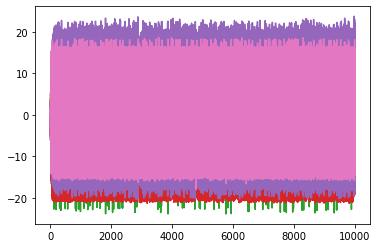

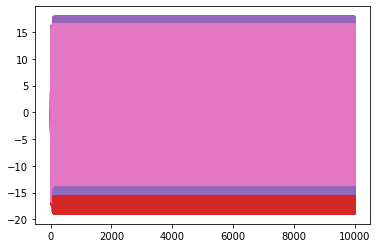

<Figure size 432x288 with 0 Axes>

In [32]:
seed = 2
ep_length = 10000
policy = policy_dict['identity'][seed]
env = gym.make(env_name)
%time o,a,r,_ = do_long_rollout(env, policy, ep_length= ep_length)
print((o[:, 1] < -1).any() or (o[:,1] > 1).any())
#o,a,r,l = do_rollout(env, policy, render=True)

plt.plot(o)
plt.figure()

print(sum(r))
# ==============
policy = policy_dict['mdim_div'][seed]
%time o2,a2,r2,_ = do_long_rollout(env, policy, ep_length=ep_length)
#o2,a2,r2,l2 = do_rollout(env, policy, render=True)
plt.plot(o2)
plt.figure()

print(sum(r2))

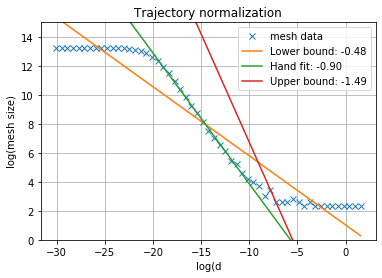

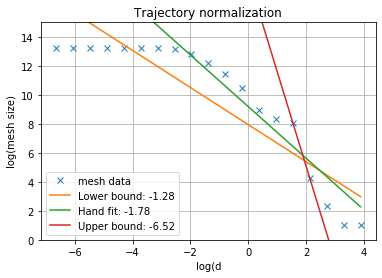

In [33]:
policy = policy_dict['mdim_div'][seed]
target2 = (o2[200:] - o2.mean(dim=0))/o2.std(dim=0)
popt_lower, ms, dv = compute_meshdim(target2)

xdata = np.log2(dv[:-1])
ydata = np.log2(ms[:-1])

slopes =  (ydata[:-1] - ydata[1:])/ (xdata[:-1] - xdata[1:])
min_slope = slopes.min()
min_idx = slopes.argmin()

start = 20; stop = -20
def f(x, m, b):
    return m * x + b

popt_hand, pcov_hand = opt.curve_fit(f, xdata[start:stop], ydata[start:stop])


plt.plot(xdata, ydata,'x')
plt.plot(xdata, popt_lower[0]*xdata + popt_lower[1])
plt.plot(xdata, popt_hand[0]*xdata + popt_hand[1])
plt.plot(xdata, (xdata-xdata[min_idx])*min_slope + ydata[min_idx])
plt.ylim([0,15])
plt.grid()
plt.xlabel("log(d")
plt.ylabel("log(mesh size)")

plt.title("Trajectory normalization")
plt.legend(['mesh data', 
            f"Lower bound: {popt_lower[0]:.2f}", 
            f"Hand fit: {popt_hand[0]:.2f}",  
            f"Upper bound: {min_slope:.2f}"])
plt.figure()



policy = policy_dict['identity'][seed]
target2 = (o[200:] - o.mean(dim=0))/o.std(dim=0)
popt_lower, ms, dv = compute_meshdim(target2)

xdata = np.log2(dv[:-1])
ydata = np.log2(ms[:-1])

slopes =  (ydata[:-1] - ydata[1:])/ (xdata[:-1] - xdata[1:])
min_slope = slopes.min()
min_idx = slopes.argmin()

start = 6; stop = -2
def f(x, m, b):
    return m * x + b

popt_hand, pcov_hand = opt.curve_fit(f, xdata[start:stop], ydata[start:stop])


plt.plot(xdata, ydata,'x')
plt.plot(xdata, popt_lower[0]*xdata + popt_lower[1])
plt.plot(xdata, popt_hand[0]*xdata + popt_hand[1])
plt.plot(xdata, (xdata-xdata[min_idx])*min_slope + ydata[min_idx])
plt.ylim([0,15])
plt.grid()
plt.xlabel("log(d")
plt.ylabel("log(mesh size)")

plt.title("Trajectory normalization")
plt.legend(['mesh data', 
            f"Lower bound: {popt_lower[0]:.2f}", 
            f"Hand fit: {popt_hand[0]:.2f}",  
            f"Upper bound: {min_slope:.2f}"])


#plt.legend(['id', 'mesh'])

CPU times: user 158 ms, sys: 0 ns, total: 158 ms
Wall time: 158 ms
tensor([5078.5879])
CPU times: user 253 ms, sys: 0 ns, total: 253 ms
Wall time: 252 ms
tensor([4111.5015])


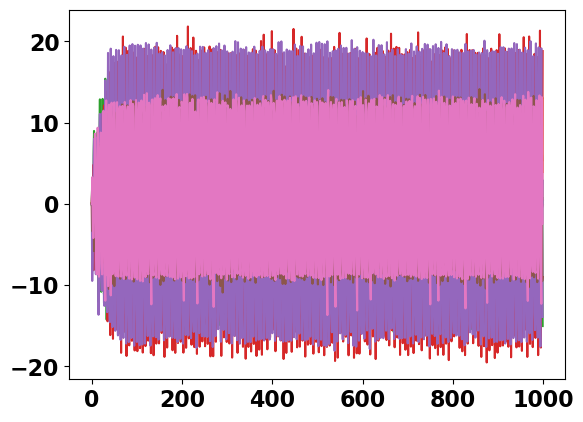

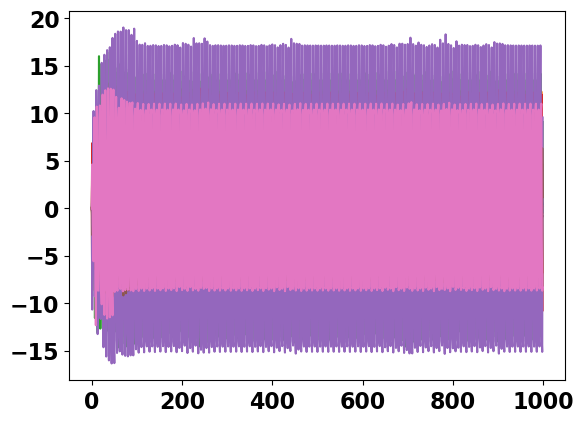

<Figure size 640x480 with 0 Axes>

In [107]:
seed = 0
ep_length = 10000
policy = policy_dict['identity'][seed]
env = gym.make(env_name)
%time o,a,r,_ = do_long_rollout(env, policy, ep_length=1000)
#o,a,r,l = do_rollout(env, policy, render=True)

plt.plot(o)
plt.figure()

print(sum(r))
# ==============
policy = policy_dict['mdim_div'][seed]
%time o2,a2,r2,_ = do_long_rollout(env, policy, ep_length=1000)
#o2,a2,r2,l2 = do_rollout(env, policy, render=True)
plt.plot(o2)
plt.figure()

print(sum(r2))

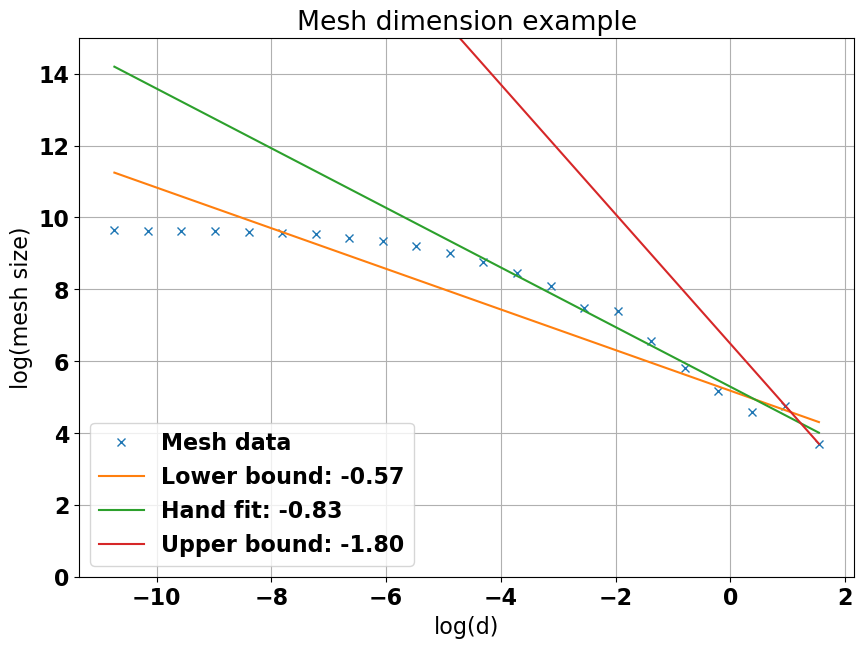

<Figure size 640x480 with 0 Axes>

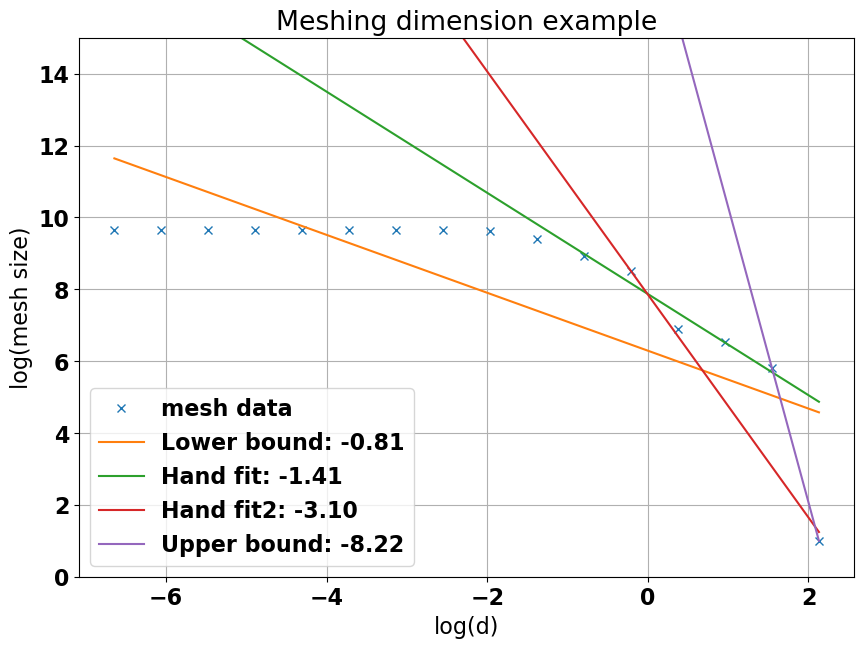

In [128]:
policy = policy_dict['mdim_div'][seed]
target2 = (o2[200:] - o2.mean(dim=0))/o2.std(dim=0)
popt_lower, ms, dv = compute_meshdim(target2)

xdata = np.log2(dv[:-1])
ydata = np.log2(ms[:-1])

slopes =  (ydata[:-1] - ydata[1:])/ (xdata[:-1] - xdata[1:])
min_slope = slopes.min()
min_idx = slopes.argmin()

start = 10; stop = -1
def f(x, m, b):
    return m * x + b

popt_hand, pcov_hand = opt.curve_fit(f, xdata[start:stop], ydata[start:stop])

import matplotlib

#matplotlib.style.use('seaborn')
matplotlib.style.use('default')

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)
plt.subplots(1,1, figsize=(10,7))
plt.plot(xdata, ydata,'x')
plt.plot(xdata, popt_lower[0]*xdata + popt_lower[1])
plt.plot(xdata, popt_hand[0]*xdata + popt_hand[1])
plt.plot(xdata, (xdata-xdata[min_idx])*min_slope + ydata[min_idx])
plt.ylim([0,15])
plt.grid()
plt.xlabel("log(d)")
plt.ylabel("log(mesh size)")

plt.title("Mesh dimension example")
plt.legend(['Mesh data', 
            f"Lower bound: {popt_lower[0]:.2f}", 
            f"Hand fit: {popt_hand[0]:.2f}",  
            f"Upper bound: {min_slope:.2f}"])
plt.figure()


policy = policy_dict['identity'][seed]
target2 = (o[200:] - o.mean(dim=0))/o.std(dim=0)
popt_lower, ms, dv = compute_meshdim(target2)

xdata = np.log2(dv[:-1])
ydata = np.log2(ms[:-1])

slopes =  (ydata[:-1] - ydata[1:])/ (xdata[:-1] - xdata[1:])
min_slope = slopes.min()
min_idx = slopes.argmin()

start = 10; stop = -1
def f(x, m, b):
    return m * x + b

popt_hand, pcov_hand = opt.curve_fit(f, xdata[start:stop], ydata[start:stop])


start = 10; stop = None
def f(x, m, b):
    return m * x + b

popt_hand2, pcov_hand2 = opt.curve_fit(f, xdata[start:stop], ydata[start:stop])

popt_hand2[0] -= .75



plt.subplots(1,1, figsize=(10,7))
plt.plot(xdata, ydata,'x')
plt.plot(xdata, popt_lower[0]*xdata + popt_lower[1])
plt.plot(xdata, popt_hand[0]*xdata + popt_hand[1])
plt.plot(xdata, popt_hand2[0]*xdata + popt_hand2[1])
plt.plot(xdata, (xdata-xdata[min_idx])*min_slope + ydata[min_idx])
plt.ylim([0,15])
plt.grid()
plt.xlabel("log(d)")
plt.ylabel("log(mesh size)")

plt.title("Meshing dimension example")
plt.legend(['mesh data', 
            f"Lower bound: {popt_lower[0]:.2f}", 
            f"Hand fit: {popt_hand[0]:.2f}",
            f"Hand fit2: {popt_hand2[0]:.2f}",  
            f"Upper bound: {min_slope:.2f}"])






#plt.legend(['id', 'mesh'])

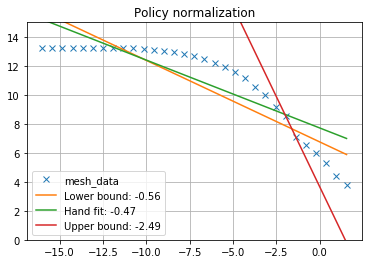

In [29]:
policy = policy_dict['mdim_div'][seed]
target2 = (o2[200:] - policy.state_means)/policy.state_std
popt_lower, ms, dv = compute_meshdim(target2)

xdata = np.log2(dv[:-1])
ydata = np.log2(ms[:-1])

slopes =  (ydata[:-1] - ydata[1:])/ (xdata[:-1] - xdata[1:])
min_slope = slopes.min()
min_idx = slopes.argmin()

start = 0; stop = -1
def f(x, m, b):
    return m * x + b

popt_hand, pcov_hand = opt.curve_fit(f, xdata[start:stop], ydata[start:stop])


plt.plot(xdata, ydata,'x')
plt.plot(xdata, popt_lower[0]*xdata + popt_lower[1])
plt.plot(xdata, popt_hand[0]*xdata + popt_hand[1])
plt.plot(xdata, (xdata-xdata[min_idx])*min_slope + ydata[min_idx])
plt.ylim([0,15])

plt.title("Policy normalization")
plt.legend(['mesh_data', 
            f"Lower bound: {popt_lower[0]:.2f}", 
            f"Hand fit: {popt_hand[0]:.2f}",  
            f"Upper bound: {min_slope:.2f}"])

plt.grid()

In [30]:
policy = policy_dict['mdim_div'][seed]

target2 = o2[200:]
#target2 = (o[200:] - o[200:].mean())/(o[200:].std())


popt_lower, ms, dv = compute_meshdim(target2)

xdata = np.log2(dv[:-1])
ydata = np.log2(ms[:-1])

slopes =  (ydata[:-1] - ydata[1:])/ (xdata[:-1] - xdata[1:])
min_slope = slopes.min()
min_idx = slopes.argmin()

start = 20; stop = -20
def f(x, m, b):
    return m * x + b

popt_hand, pcov_hand = opt.curve_fit(f, xdata[start:stop], ydata[start:stop])


plt.plot(xdata, ydata,'x')
plt.plot(xdata, popt_lower[0]*xdata + popt_lower[1])
plt.plot(xdata, popt_hand[0]*xdata + popt_hand[1])
plt.plot(xdata, (xdata-xdata[min_idx])*min_slope + ydata[min_idx])
plt.ylim([0,15])

plt.title("No normalization")
plt.legend(['mesh_data', 
            f"Lower bound: {popt_lower[0]:.2f}", 
            f"Hand fit: {popt_hand[0]:.2f}",  
            f"Upper bound: {min_slope:.2f}"])

plt.grid()
plt.figure()



ValueError: `ydata` must not be empty!

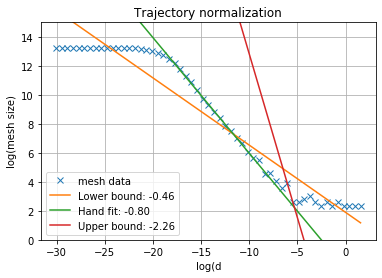

In [58]:
policy = policy_dict['identity'][seed]
target2 = (o2[200:] - o2.mean(dim=0))/o2.std(dim=0)
popt_lower, ms, dv = compute_meshdim(target2)

xdata = np.log2(dv[:-1])
ydata = np.log2(ms[:-1])

slopes =  (ydata[:-1] - ydata[1:])/ (xdata[:-1] - xdata[1:])
min_slope = slopes.min()
min_idx = slopes.argmin()

start = 20; stop = -20
def f(x, m, b):
    return m * x + b

popt_hand, pcov_hand = opt.curve_fit(f, xdata[start:stop], ydata[start:stop])


plt.plot(xdata, ydata,'x')
plt.plot(xdata, popt_lower[0]*xdata + popt_lower[1])
plt.plot(xdata, popt_hand[0]*xdata + popt_hand[1])
plt.plot(xdata, (xdata-xdata[min_idx])*min_slope + ydata[min_idx])
plt.ylim([0,15])
plt.grid()
plt.xlabel("log(d")
plt.ylabel("log(mesh size)")

plt.title("Trajectory normalization")
plt.legend(['mesh data', 
            f"Lower bound: {popt_lower[0]:.2f}", 
            f"Hand fit: {popt_hand[0]:.2f}",  
            f"Upper bound: {min_slope:.2f}"])


#plt.legend(['id', 'mesh'])

CPU times: user 1.4 s, sys: 0 ns, total: 1.4 s
Wall time: 1.4 s
tensor([54227.4609])
CPU times: user 136 ms, sys: 0 ns, total: 136 ms
Wall time: 136 ms
tensor([6558.2715])


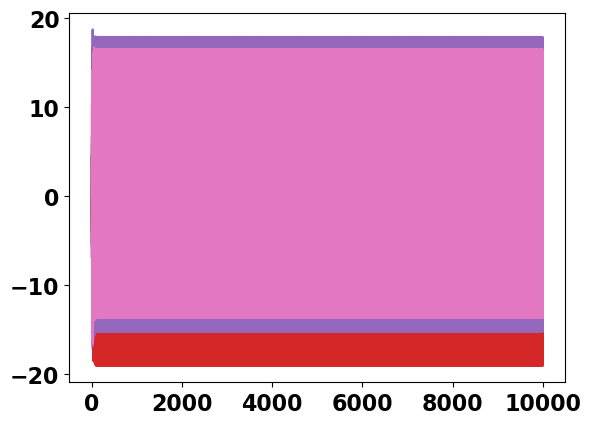

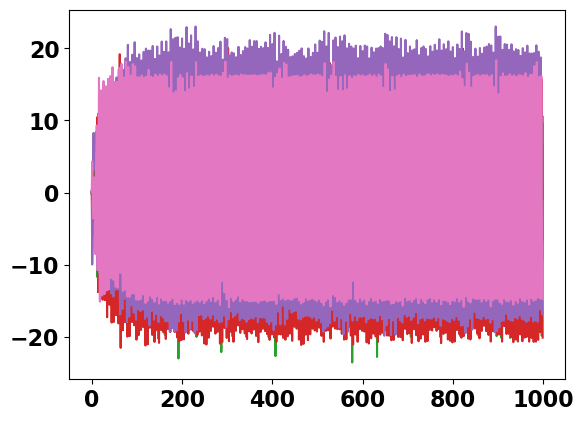

<Figure size 640x480 with 0 Axes>

In [105]:
# ==============
policy = policy_dict['mdim_div'][seed]
%time o2,a2,r2,_ = do_long_rollout(env, policy, ep_length=ep_length)
#o2,a2,r2,l2 = do_rollout(env, policy, render=True)
plt.plot(o2)
plt.figure()

print(sum(r2))

seed = 2
ep_length = 1000
policy = policy_dict['identity'][seed]
env = gym.make(env_name)
%time o,a,r,_ = do_long_rollout(env, policy, ep_length= ep_length)
#o,a,r,l = do_rollout(env, policy, render=True)

plt.plot(o)
plt.figure()

print(sum(r))

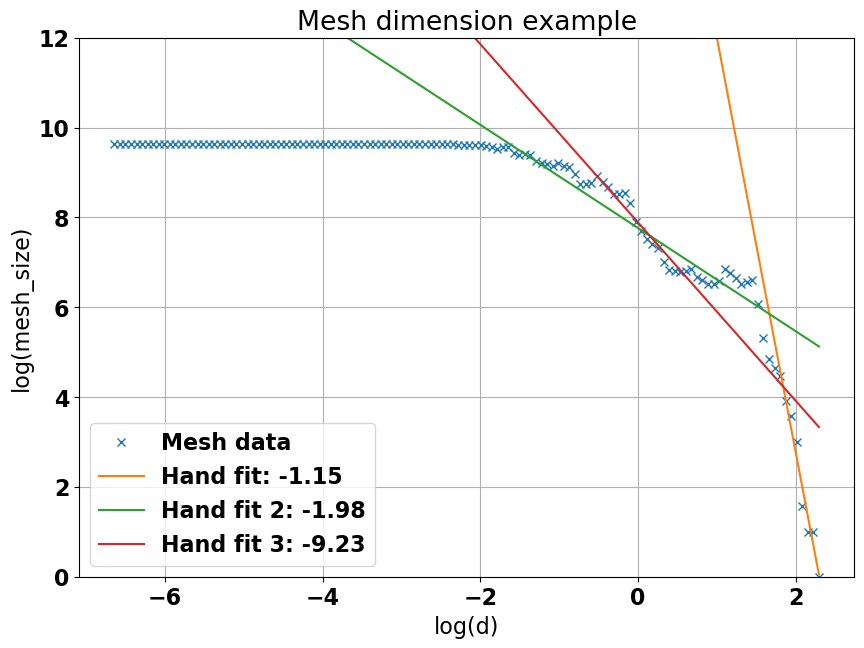

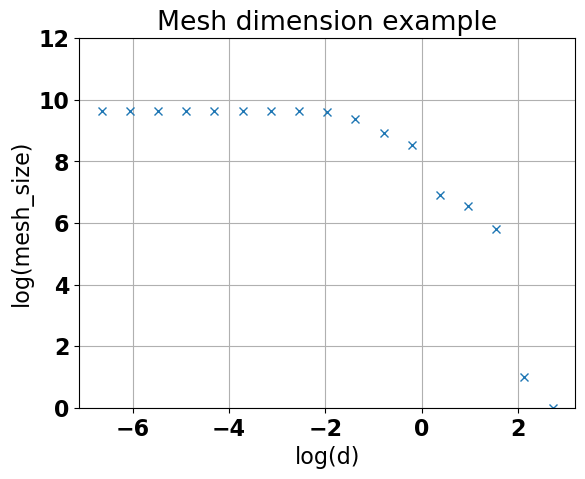

In [139]:
plt.subplots(1,1, figsize=(10,7))

popt_lower, ms, dv = compute_meshdim(target2,scaling_factor=1.05)
plt.plot(np.log2(dv), np.log2(ms),'x')
xdata0 = np.log2(dv)

slope3  = fit_and_plot(start = 120, stop = -1)
slope1  = fit_and_plot(start = 65, stop = 110)
slope2  = fit_and_plot(start = 80, stop = -1)


plt.title("Mesh dimension example")
plt.xlabel("log(d)")
plt.ylabel("log(mesh_size)")
plt.ylim(0,12)
plt.legend(["Mesh data", f"Hand fit: {slope1:.2f}", f"Hand fit 2: {slope2:.2f}", f"Hand fit 3: {slope3:.2f}"])
plt.grid()


popt_lower, ms, dv = compute_meshdim(target2,scaling_factor=1.5)
plt.figure()

plt.plot(np.log2(dv), np.log2(ms),'x')
xdata0 = np.log2(dv)
plt.title("Mesh dimension example")
plt.xlabel("log(d)")
plt.ylabel("log(mesh_size)")
plt.ylim(0,12)
plt.grid()
#plt.legend(["Mesh data", f"{slope1:.2f}", f"{slope2:.2f}", f"{slope3:.2f}"])


#slope1  = fit_and_plot(start = 80, stop = -1)


In [1]:
def do_rollout_till_fail(env, policy, ep_length, fail_cond):
    torch.autograd.set_grad_enabled(False)

    act_list = []
    obs_list = []
    rew_list = []

    dtype = torch.float32
    obs = env.reset()
    done = False
    cur_step = 0

    while cur_step < ep_length:
        obs = torch.as_tensor(obs, dtype=dtype).detach()
        obs_list.append(obs.clone())

        act = policy(obs)
        obs, rew, done, _ = env.step(act.numpy())
        if fail_cond(obs):
            break

        act_list.append(torch.as_tensor(act.clone()))
        rew_list.append(rew)

        cur_step += 1

    ep_length = len(rew_list)
    ep_obs = torch.stack(obs_list)
    ep_act = torch.stack(act_list)
    ep_rew = torch.tensor(rew_list, dtype=dtype)
    ep_rew = ep_rew.reshape(-1, 1)

    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew, ep_length


seed = 1
ep_length = 100000

env = gym.make(env_name)
def fail_fn(o):
    return not (-1 < o[1] < 1)

l1 = [] 
l2 = [] 

num_trials=100


for trial in range(num_trials):
    policy = policy_dict['mdim_div'][seed]
    %time o,a,r,l = do_rollout_till_fail(env, policy, ep_length= ep_length, fail_cond=fail_fn)
    l1.append(l)

    #o,a,r,l = do_rollout(env, policy, render=True)

    # ==============
    #policy = policy_dict['mdim_div'][seed]
    #%time o,a,r,l = do_rollout_till_fail(env, policy, ep_length= ep_length, fail_cond=fail_fn)
    #l2.append(l)


    #o2,a2,r2,l2 = do_rollout(env, policy, render=True)

    #print(sum(r2))

NameError: name 'gym' is not defined

In [138]:
print(f"{np.array(l1).mean()} pm {np.array(l1).std()}")

66165.88 pm 36887.04631907521


In [ ]:
l1

In [2]:
from seagul.rl.ars.ars_pipe import ars
from seagul.nn import MLP
from common import *
from seagul.mesh import create_mesh, variation_dim, compute_meshdim
import scipy.optimize as opt
import torch
import matplotlib.pyplot as plt
import time
import copy
import gym
import torch

import xarray as xr
import numpy as np
import pandas as pd

import os

from mujoco_py.generated import const
from PIL import Image
torch.autograd.set_grad_enabled(False)

data = torch.load("./data_mcshdim4/HalfCheetah-v2.xr")
policy_dict = data.policy_dict

data = torch.load("./data17/HalfCheetah-v2.xr")
policy_dict['identity'] = data.policy_dict['identity']

env_name = "HalfCheetah-v2"
post_name = 'identity'
seed = 2
policy = policy_dict[post_name][seed]

act_list = []
obs_list = []
rew_list = []

dtype = torch.float32
done = False
cur_step = 0

env = gym.make(env_name)
obs = env.reset()
env.render(mode='rgb_array')

env.unwrapped.viewer.cam.type = const.CAMERA_FIXED
env.unwrapped.viewer.cam.fixedcamid+=1
save_dir = f'./images/{env_name}_{post_name}_{seed}/'

os.makedirs(save_dir, exist_ok=True)
while not done:
    obs = torch.as_tensor(obs, dtype=dtype).detach()
    obs_list.append(obs.clone())

    act = policy(obs)
    obs, rew, done, _ = env.step(act.numpy())
    
    imarr = env.render(mode='rgb_array')
    im = Image.fromarray(imarr)
    im.save(save_dir + str(cur_step) + ".png")

    act_list.append(torch.as_tensor(act.clone()))
    rew_list.append(rew)

    cur_step += 1

ep_length = len(rew_list)
ep_obs = torch.stack(obs_list)
ep_act = torch.stack(act_list)
ep_rew = torch.tensor(rew_list, dtype=dtype)
ep_rew = ep_rew.reshape(-1, 1)

torch.autograd.set_grad_enabled(True)